# College Scorecard Data Analysis
## Modeling Income-Share Agreements from College Outcomes Data (US Focus)
In this notebook, we are trying to model whether a school's parameters affect the outcomes of their graduates. This is essential for creating profitable income-share agreement contracts where students' financing repayments is based on their future income.

### Kaggle Kernel Notes
We used a Kaggle Kernel given the size of our dataset and the efficiency of cloud compute and cloud storage offered by the kernel.
Below are some essential notes about this Python 3 Jupyter Notebook Environment:
- It is defined by the `kaggle/python` Docker image: https://github.com/kaggle/docker-python
- Input data files are available in the read-only `../input/` directory
- You can write up to 20GB to the current directory `/kaggle/working/` that gets preserved as output when creating version 
- You can also write temporary files to `/kaggle/temp/`, but they won't be saved outside of the current session

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing
import seaborn as sns # advanced visualisations
import matplotlib.pyplot as plt # data visualisation

In [30]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/college-scorecard-aggregated-dataset/MERGED2015_16_PP.csv
/kaggle/input/college-scorecard-aggregated-dataset/MERGED2019_20_PP.csv
/kaggle/input/college-scorecard-aggregated-dataset/CollegeScorecardDataDictionary.xlsx
/kaggle/input/college-scorecard-aggregated-dataset/MERGED2016_17_PP.csv
/kaggle/input/college-scorecard-aggregated-dataset/MERGED2021_22_PP.csv
/kaggle/input/college-scorecard-aggregated-dataset/MERGED2020_21_PP.csv
/kaggle/input/college-scorecard-aggregated-dataset/InstitutionDataDocumentation.pdf
/kaggle/input/college-scorecard-aggregated-dataset/MERGED2018_19_PP.csv
/kaggle/input/college-scorecard-aggregated-dataset/FieldOfStudyDataDocumentation.pdf
/kaggle/input/college-scorecard-aggregated-dataset/MERGED2017_18_PP.csv


## Exploratory Data Analysis

### Data Importation & Consolidation

In [35]:
# Define the file names for the year we want to import data for
years = [2018,2017,2016,2015] # Years of data we are interested in
fnames = list()
for year in years:
    fname = "/kaggle/input/college-scorecard-aggregated-dataset/MERGED" + str(year) + "_" + str(year+1)[2:] + "_PP.csv" #Based on format of file names
    fnames.append(fname)
print(len(fnames))

4


In [44]:
## Import first dataset – the base year dataset
data = pd.read_csv(str(fnames[0]), low_memory=False)
data["DATAYEAR"] = years[0]
dshapes = [data.shape]

## Import other datasets and concat into the base dataset
for i in range(1,len(fnames)):
    df = pd.read_csv(str(fnames[i]), low_memory=False)
    df["DATAYEAR"] = years[i]
    dshapes.append(df.shape) # Track the shape of the added data
    data = pd.concat([data, df], ignore_index=True)
    
print(data.shape, dshapes)
data.head()

(28823, 3233) [(6807, 3233), (7112, 3233), (7238, 3233), (7666, 3233)]


,UNITID,OPEID,OPEID6,INSTNM,CITY,STABBR,ZIP,ACCREDAGENCY,INSTURL,NPCURL,...,OMENRUP_NOPELL_FIRSTTIME,OMENRYP_NOPELL_NOTFIRSTTIME,OMENRAP_NOPELL_NOTFIRSTTIME,OMAWDP8_NOPELL_NOTFIRSTTIME,OMENRUP_NOPELL_NOTFIRSTTIME,OMACHT8_NOPELL_ALL,OMACHT8_NOPELL_FIRSTTIME,OMACHT8_NOPELL_NOTFIRSTTIME,ADDR,DATAYEAR
0,100654,100200,1002,Alabama A & M University,Normal,AL,35762,NaN,NaN,NaN,...,0.2215,0.0099,0.3366,0.4455,0.2079,390.0,289.0,101.0,NaN,2018
1,100663,105200,1052,University of Alabama at Birmingham,Birmingham,AL,35294-0110,NaN,NaN,NaN,...,0.1447,0.0131,0.1783,0.5402,0.2684,2160.0,1016.0,1144.0,NaN,2018
2,100690,2503400,25034,Amridge University,Montgomery,AL,36117-3553,NaN,NaN,NaN,...,0.0000,0.0000,0.0000,0.2414,0.7586,32.0,3.0,29.0,NaN,2018
3,100706,105500,1055,University of Alabama in Huntsville,Huntsville,AL,35899,NaN,NaN,NaN,...,0.1298,0.0214,0.2681,0.5148,0.1957,1055.0,447.0,608.0,NaN,2018
4,100724,100500,1005,Alabama State University,Montgomery,AL,36104-0271,NaN,NaN,NaN,...,0.2201,0.0000,0.4400,0.4133,0.1467,284.0,209.0,75.0,NaN,2018


After the import, we can see the concatenate was straight forward:
- there was an equal number of columns across all datasets
- The final dataset has 28,823, equal to the sum of row on the individual datasets (6807,7112,7238,7666)

### Handle High Dimensionality

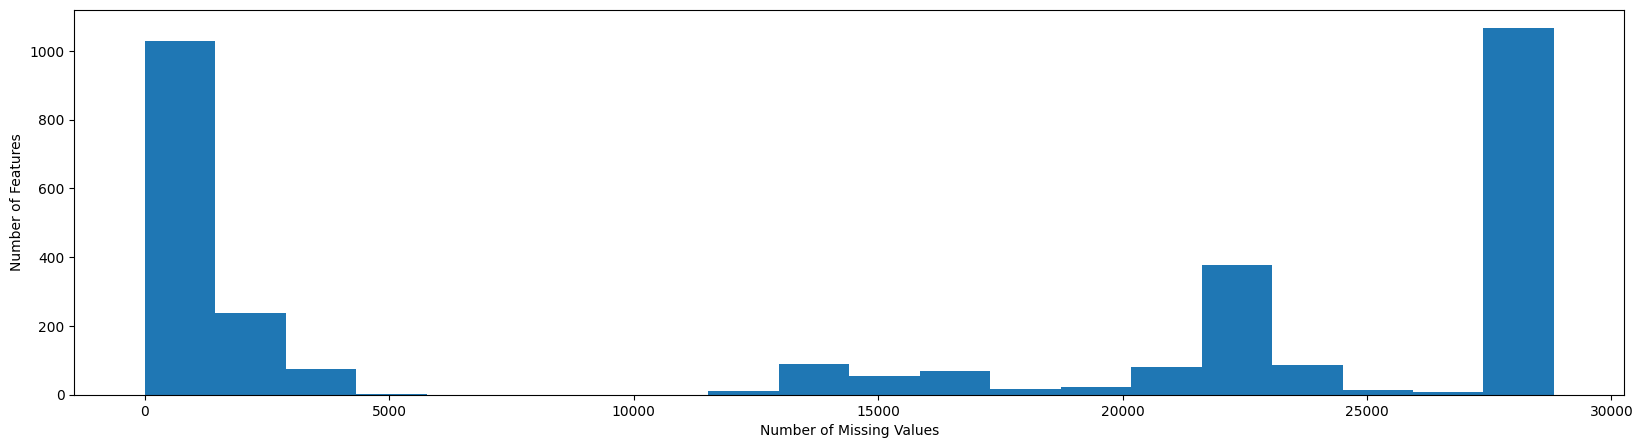

In [60]:
missing_values = data.isnull().sum(axis=0) # Identify all null values in the data
plt.figure(figsize=(20,5))
plt.hist(missing_values,bins=20,label=True)
plt.ylabel("Number of Features")
plt.xlabel("Number of Missing Values")
plt.show()

In [61]:
to_drop = list()
threshold = 0.2 * data.shape[0] #1738 seems to be the number from 0.2 to 0.4
for column in list(data.columns):
    if data[column].isnull().sum() > threshold:
        to_drop.append(column)
        
print(len(to_drop))

1890


In [64]:
data = data.drop(to_drop,axis=1) ## Drop columns with extreme missingness
data = data.drop_duplicates() ## Drop duplicate rows
print(data.shape)
data.head()

(28823, 1343)


,UNITID,OPEID,OPEID6,INSTNM,CITY,STABBR,ZIP,SCH_DEG,MAIN,NUMBRANCH,...,IRPS_ASIAN,IRPS_BLACK,IRPS_HISP,IRPS_NHPI,IRPS_NRA,IRPS_UNKN,IRPS_WHITE,IRPS_WOMEN,IRPS_MEN,DATAYEAR
0,100654,100200,1002,Alabama A & M University,Normal,AL,35762,3.0,1,1,...,0.0965,0.6564,0.0000,0.0000,0.1158,0.0039,0.1236,0.4672,0.5328,2018
1,100663,105200,1052,University of Alabama at Birmingham,Birmingham,AL,35294-0110,3.0,1,1,...,0.1522,0.0630,0.0307,0.0004,0.0471,0.0012,0.6968,0.4141,0.5859,2018
2,100690,2503400,25034,Amridge University,Montgomery,AL,36117-3553,3.0,1,1,...,0.0000,0.0909,0.0000,0.0000,0.0000,0.0000,0.9091,0.1515,0.8485,2018
3,100706,105500,1055,University of Alabama in Huntsville,Huntsville,AL,35899,3.0,1,1,...,0.1729,0.0490,0.0202,0.0029,0.0461,0.0000,0.7061,0.4496,0.5504,2018
4,100724,100500,1005,Alabama State University,Montgomery,AL,36104-0271,3.0,1,1,...,0.1385,0.6104,0.0130,0.0043,0.0000,0.0000,0.2338,0.5022,0.4978,2018


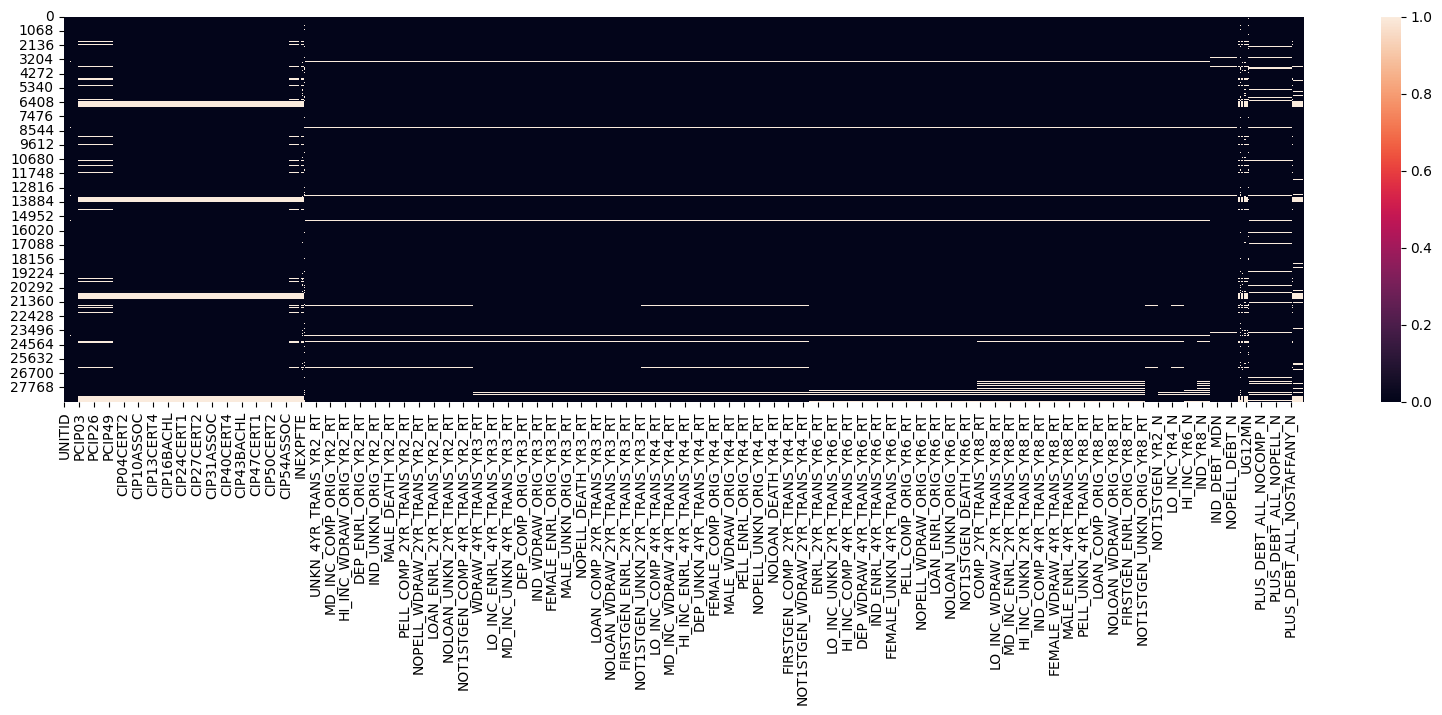

In [66]:
plt.figure(figsize=(20,5))
sns.heatmap(data.isnull())
plt.show()

In [67]:
data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28823 entries, 0 to 28822
Data columns (total 1343 columns):
 #     Column                            Dtype  
---    ------                            -----  
 0     UNITID                            int64  
 1     OPEID                             int64  
 2     OPEID6                            int64  
 3     INSTNM                            object 
 4     CITY                              object 
 5     STABBR                            object 
 6     ZIP                               object 
 7     SCH_DEG                           float64
 8     MAIN                              int64  
 9     NUMBRANCH                         int64  
 10    PREDDEG                           int64  
 11    HIGHDEG                           int64  
 12    CONTROL                           int64  
 13    ST_FIPS                           int64  
 14    REGION                            int64  
 15    PCIP01                            float64
 16    

In [70]:
data.IRPS_BLACK

0        0.6564
1        0.0630
2        0.0909
3        0.0490
4        0.6104
          ...  
28818       NaN
28819       NaN
28820       NaN
28821       NaN
28822       NaN
Name: IRPS_BLACK, Length: 28823, dtype: float64